In [3]:
import os
from os import listdir
import numpy as np
import nibabel as nib #for reading .nii.gz format MRI files
import matplotlib.pyplot as plt
import pandas as pd
#import cv2 #opencv

In [2]:
import timm
import torch

### Take a look at models

In [6]:
# default model with classifier
m0 = timm.create_model("mobilevit_xxs.cvnets_in1k", pretrained=True)
print(m0)

ByobNet(
  (stem): ConvNormAct(
    (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNormAct2d(
      16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
  )
  (stages): Sequential(
    (0): Sequential(
      (0): BottleneckBlock(
        (shortcut): Identity()
        (conv1_1x1): ConvNormAct(
          (conv): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
        )
        (conv2_kxk): ConvNormAct(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
          

In [12]:
# We want Penultimate Layer Features (Pre-Classifier Features), not classification
# this one ends with:
#   (fc): Identity()
#   (flatten): Identity()
m1 = timm.create_model(
    "mobilevit_xxs.cvnets_in1k", 
    pretrained=True, 
    num_classes=0, 
    global_pool='')


# pretrained weights need <batch B, 3 channels, H, W>:
# ex. (1, 3, 224, 224) -> torch.Size([1,1000]) if classifier
# ex.                  -> torch.Size([1, 320, 7, 7]) if preclassifier (no classifier head & pooling)
# ex. (1, 3, 96, 96)   -> torch.Size([1, 320, 3, 3]) if classifier
x = torch.randn(1, 3, 96, 96) 
o = m1(x)  
#print(m1)

In [4]:
# MobileViTv2
# This one with LinearTransformerBlock(...), LinearSelfAttention(...) classes 
#   crop_pct=0.888?
m2 = timm.create_model(
    "mobilevitv2_050.cvnets_in1k", 
    pretrained=True, 
    num_classes=0, 
    global_pool='')

# pretrained weights need <batch B, 3 channels, H, W>:
# ex. (1, 3, 224, 224) -> torch.Size([1,1000]) if classifier
# ex.                  -> torch.Size([1, 256, 8, 8]) if preclassifier (no classifier head & pooling)
# ex. (1, 3, 96, 96)   -> torch.Size([1, 256, 4, 4]) if classifier
x = torch.randn(1, 3, 224, 224) 
o = m2(x)
print(o.shape)  
print(m2)

torch.Size([1, 256, 8, 8])
ByobNet(
  (stem): ConvNormAct(
    (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNormAct2d(
      16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
  )
  (stages): Sequential(
    (0): Sequential(
      (0): BottleneckBlock(
        (conv1_1x1): ConvNormAct(
          (conv): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
        )
        (conv2_kxk): ConvNormAct(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (a

### Load Images from csv

In [5]:
os.chdir("/Users/rita/Desktop")
cwd = os.getcwd() #/Users/rita/Desktop/
print(cwd)

/Users/rita/Desktop


In [6]:
file_dir = 'harini_lab/PROSTATEx/Files/lesions/'
csvFile_image = pd.read_csv(os.path.join(file_dir,'image_list.csv'))
csvFile_score = pd.read_csv(os.path.join(file_dir,'prostatex_classes.csv'))

img_dir_ADC = os.path.join(file_dir, 'Images/ADC') #lesions/Images/ADC/X.nii.gz
img_dir_T2 = os.path.join(file_dir, 'Images/T2') #lesions/Images/T2/X.nii.gz


(84, 128, 3)


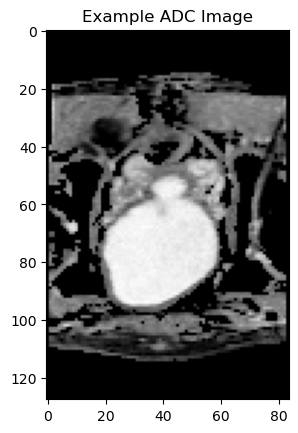

In [7]:
# example images
img_filename_ADC, img_filename_T2 = csvFile_image.iloc[10] #change for different imgs

img_complete_path_ADC = os.path.join(img_dir_ADC, img_filename_ADC) + '.nii.gz'
img_ADC = nib.load(img_complete_path_ADC)
imgdata_ADC = img_ADC.get_fdata() #(84, 128, 19)

slice_ADC = imgdata_ADC[:,:,13:16] #(mask at 13~17) #(84,128)
plt.imshow(slice_ADC[:,:,2].T, cmap='Greys_r'); plt.title("Example ADC Image")

img_complete_path_T2 = os.path.join(img_dir_T2, img_filename_T2) + '.nii.gz'
img_T2 = nib.load(img_complete_path_T2)
imgdata_T2 = img_T2.get_fdata() #(384, 384, 19)

slice_T2 = imgdata_T2[:,:,13:16] #changed
#plt.imshow(slice_T2[:,:,2].T, cmap='Greys_r'); plt.title("Example T2 Image")
print(slice_ADC.shape) 

In [8]:
# save
np.save('ex_multi_slice_ADC', slice_ADC)

### Playground

Text(0.5, 1.0, 'Example ADC Image')

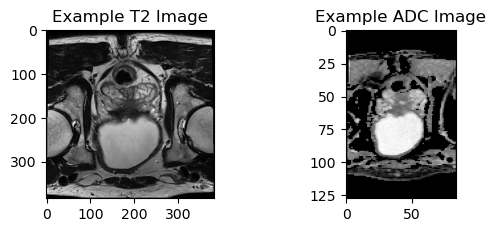

In [9]:
#load example image
slice_ADC = np.load('ex_multi_slice_ADC.npy') 
slice_T2 = np.load('ex_multi_slice_T2.npy') 

fig = plt.figure()
fig.add_subplot(2, 2, 1); plt.imshow(slice_T2[:,:,1].T, cmap='Greys_r'); plt.title("Example T2 Image")
#slice_T2 = slice_T2.transpose(2,0,1)
#print(slice_T2.shape) 
fig.add_subplot(2, 2, 2); plt.imshow(slice_ADC[:,:,1].T, cmap='Greys_r'); plt.title("Example ADC Image")


### Visualize Feature map

In [7]:
import torchvision.transforms as trans
# Feature map
m2 = timm.create_model(
    'mobilevitv2_050.cvnets_in1k', 
    features_only=True, 
    pretrained=True)

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(m2)
transforms = timm.data.create_transform(**data_config, is_training=False)

# torchvision transforms module takes PIL image with 3 channels, need to add lines
pil_image = trans.ToPILImage()(slice_T2)
x = transforms(pil_image).unsqueeze(0) #torch.Size([1, 3, 256, 256])
print("x.shape = {}".format(x.shape))
output = m2(x) #list with len=5 tensors

for o in output:
    # print shape of each feature map in output
    # e.g.:
    #  torch.Size([1, 32, 128, 128])
    #  torch.Size([1, 64, 64, 64])
    #  torch.Size([1, 128, 32, 32])
    #  torch.Size([1, 192, 16, 16])
    #  torch.Size([1, 256, 8, 8])

    print(o.shape)


x.shape = torch.Size([1, 3, 256, 256])
torch.Size([1, 32, 128, 128])
torch.Size([1, 64, 64, 64])
torch.Size([1, 128, 32, 32])
torch.Size([1, 192, 16, 16])
torch.Size([1, 256, 8, 8])


In [11]:
# visualize feature map
fms = []

for feature_map in output:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0] #feature_map.shape[0] = 32,64,128,192,256
    fm = gray_scale.data.cpu().numpy()
    fms.append(fm)

    print(fm.shape)
    # the feature map become smaller and contain more information, "folding"???
    #(128, 128)
    #(64, 64)
    #(32, 32)
    #(16, 16)
    #(8, 8)

(128, 128)
(64, 64)
(32, 32)
(16, 16)
(8, 8)


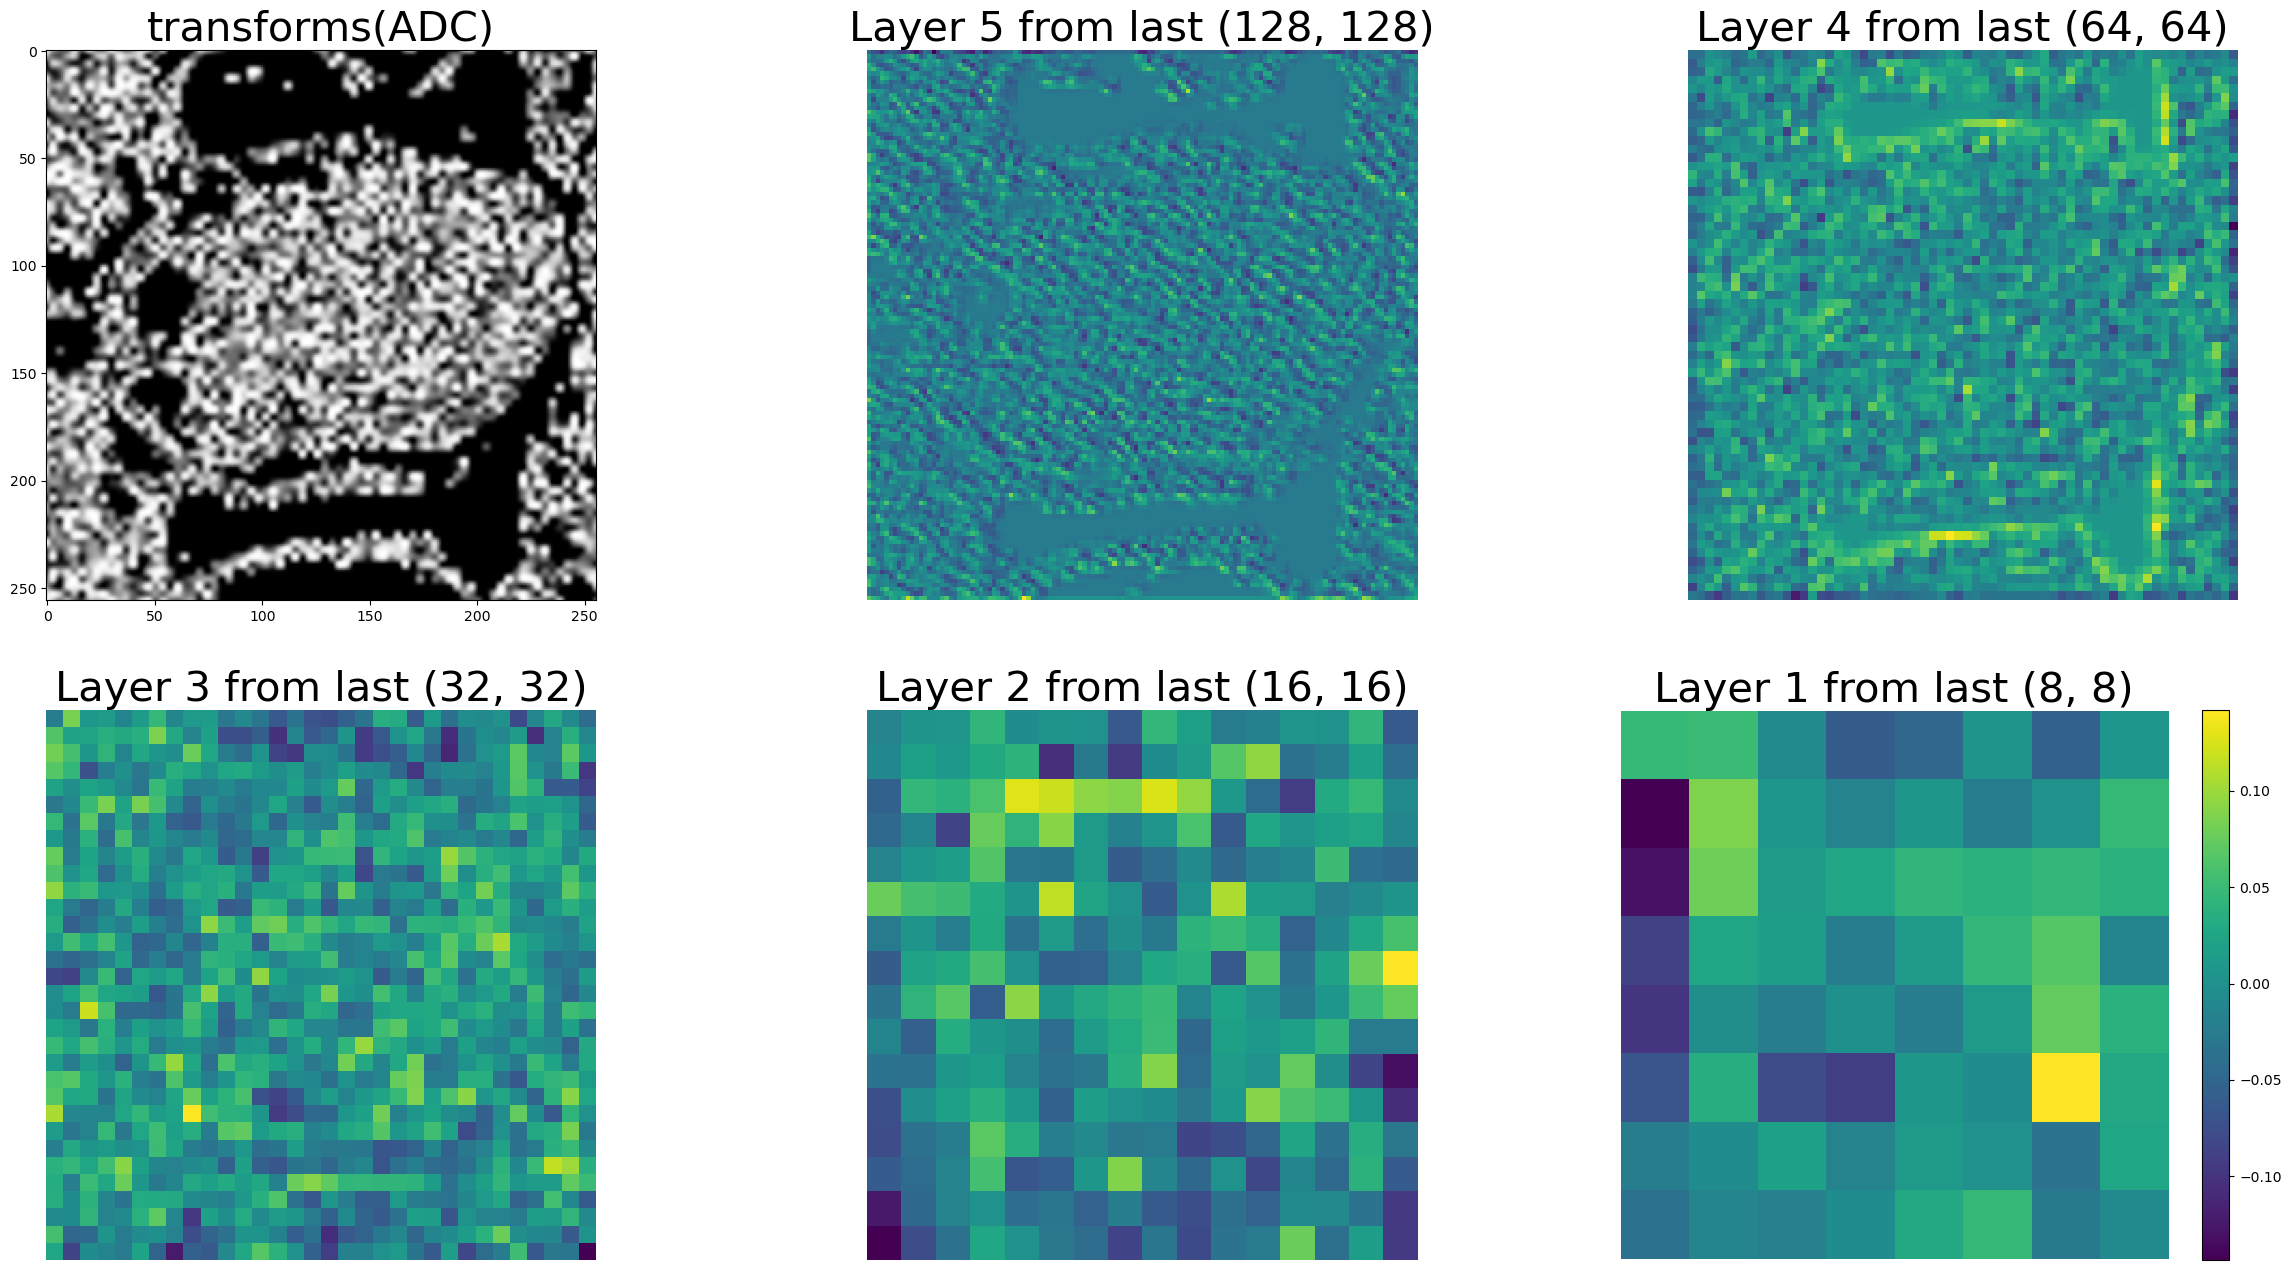

In [22]:
fig = plt.figure(figsize=(30, 50))
fig.add_subplot(6, 3, 1)
ori = plt.imshow(x.squeeze(0)[1,:,:], cmap='Greys_r'); plt.title("transforms(ADC)", fontsize=30)

for i in range(len(fms)):
    a = fig.add_subplot(6, 3, i+2)
    imgplot = plt.imshow(fms[i])
    a.axis("off")
    a.set_title("Layer {} from last {}".format(len(fms)-i, fms[i].shape), fontsize=30)
#plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')
cbar = plt.colorbar()

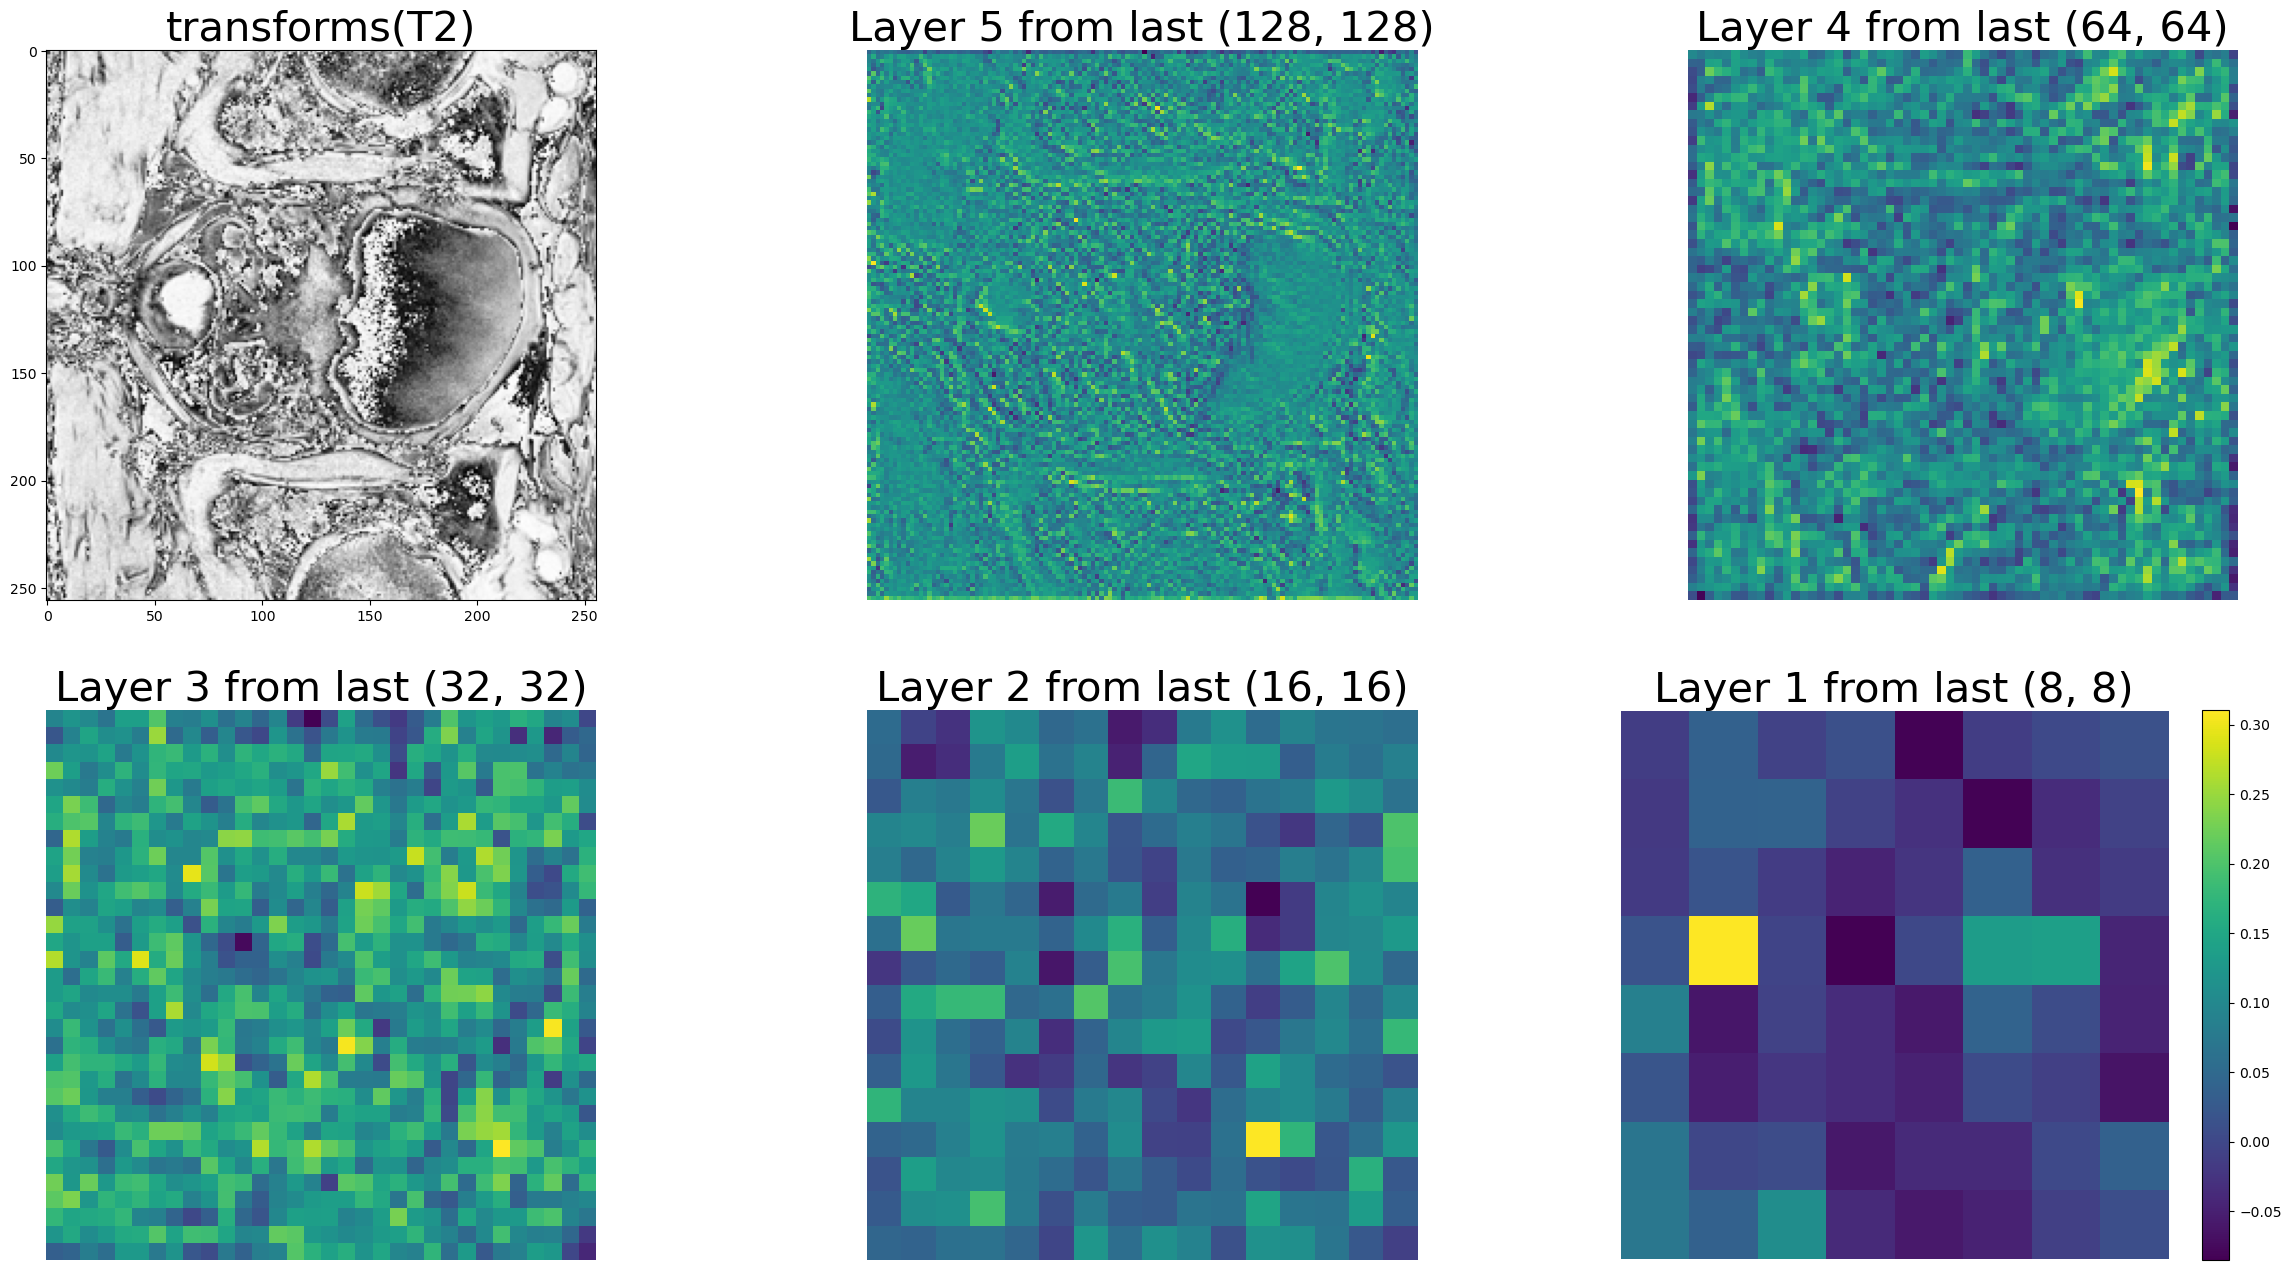

In [9]:
# temp output for T2
fig = plt.figure(figsize=(30, 50))
fig.add_subplot(6, 3, 1)
ori = plt.imshow(x.squeeze(0)[1,:,:], cmap='Greys_r'); plt.title("transforms(T2)", fontsize=30)

for i in range(len(fms)):
    a = fig.add_subplot(6, 3, i+2)
    imgplot = plt.imshow(fms[i])
    a.axis("off")
    a.set_title("Layer {} from last {}".format(len(fms)-i, fms[i].shape), fontsize=30)
#plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')
cbar = plt.colorbar()

In [10]:
# try a different model v1
import torchvision.transforms as trans

m1 = timm.create_model(
    'mobilevit_xxs.cvnets_in1k', 
    features_only=True, 
    pretrained=True)

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(m1)
transforms = timm.data.create_transform(**data_config, is_training=False)

# torchvision transforms module takes PIL image with 3 channels, need to add lines
pil_image = trans.ToPILImage()(slice_T2)
x = transforms(pil_image).unsqueeze(0) #torch.Size([1, 3, 256, 256])
print("x.shape = {}".format(x.shape))
output = m1(x) #list with len=5 tensors

for o in output:
    # print shape of each feature map in output
    # e.g.:
    #  torch.Size([1, 16, 128, 128])
    #  torch.Size([1, 24, 64, 64])
    #  torch.Size([1, 48, 32, 32])
    #  torch.Size([1, 64, 16, 16])
    #  torch.Size([1, 320, 8, 8])

    print(o.shape)

x.shape = torch.Size([1, 3, 256, 256])
torch.Size([1, 16, 128, 128])
torch.Size([1, 24, 64, 64])
torch.Size([1, 48, 32, 32])
torch.Size([1, 64, 16, 16])
torch.Size([1, 320, 8, 8])


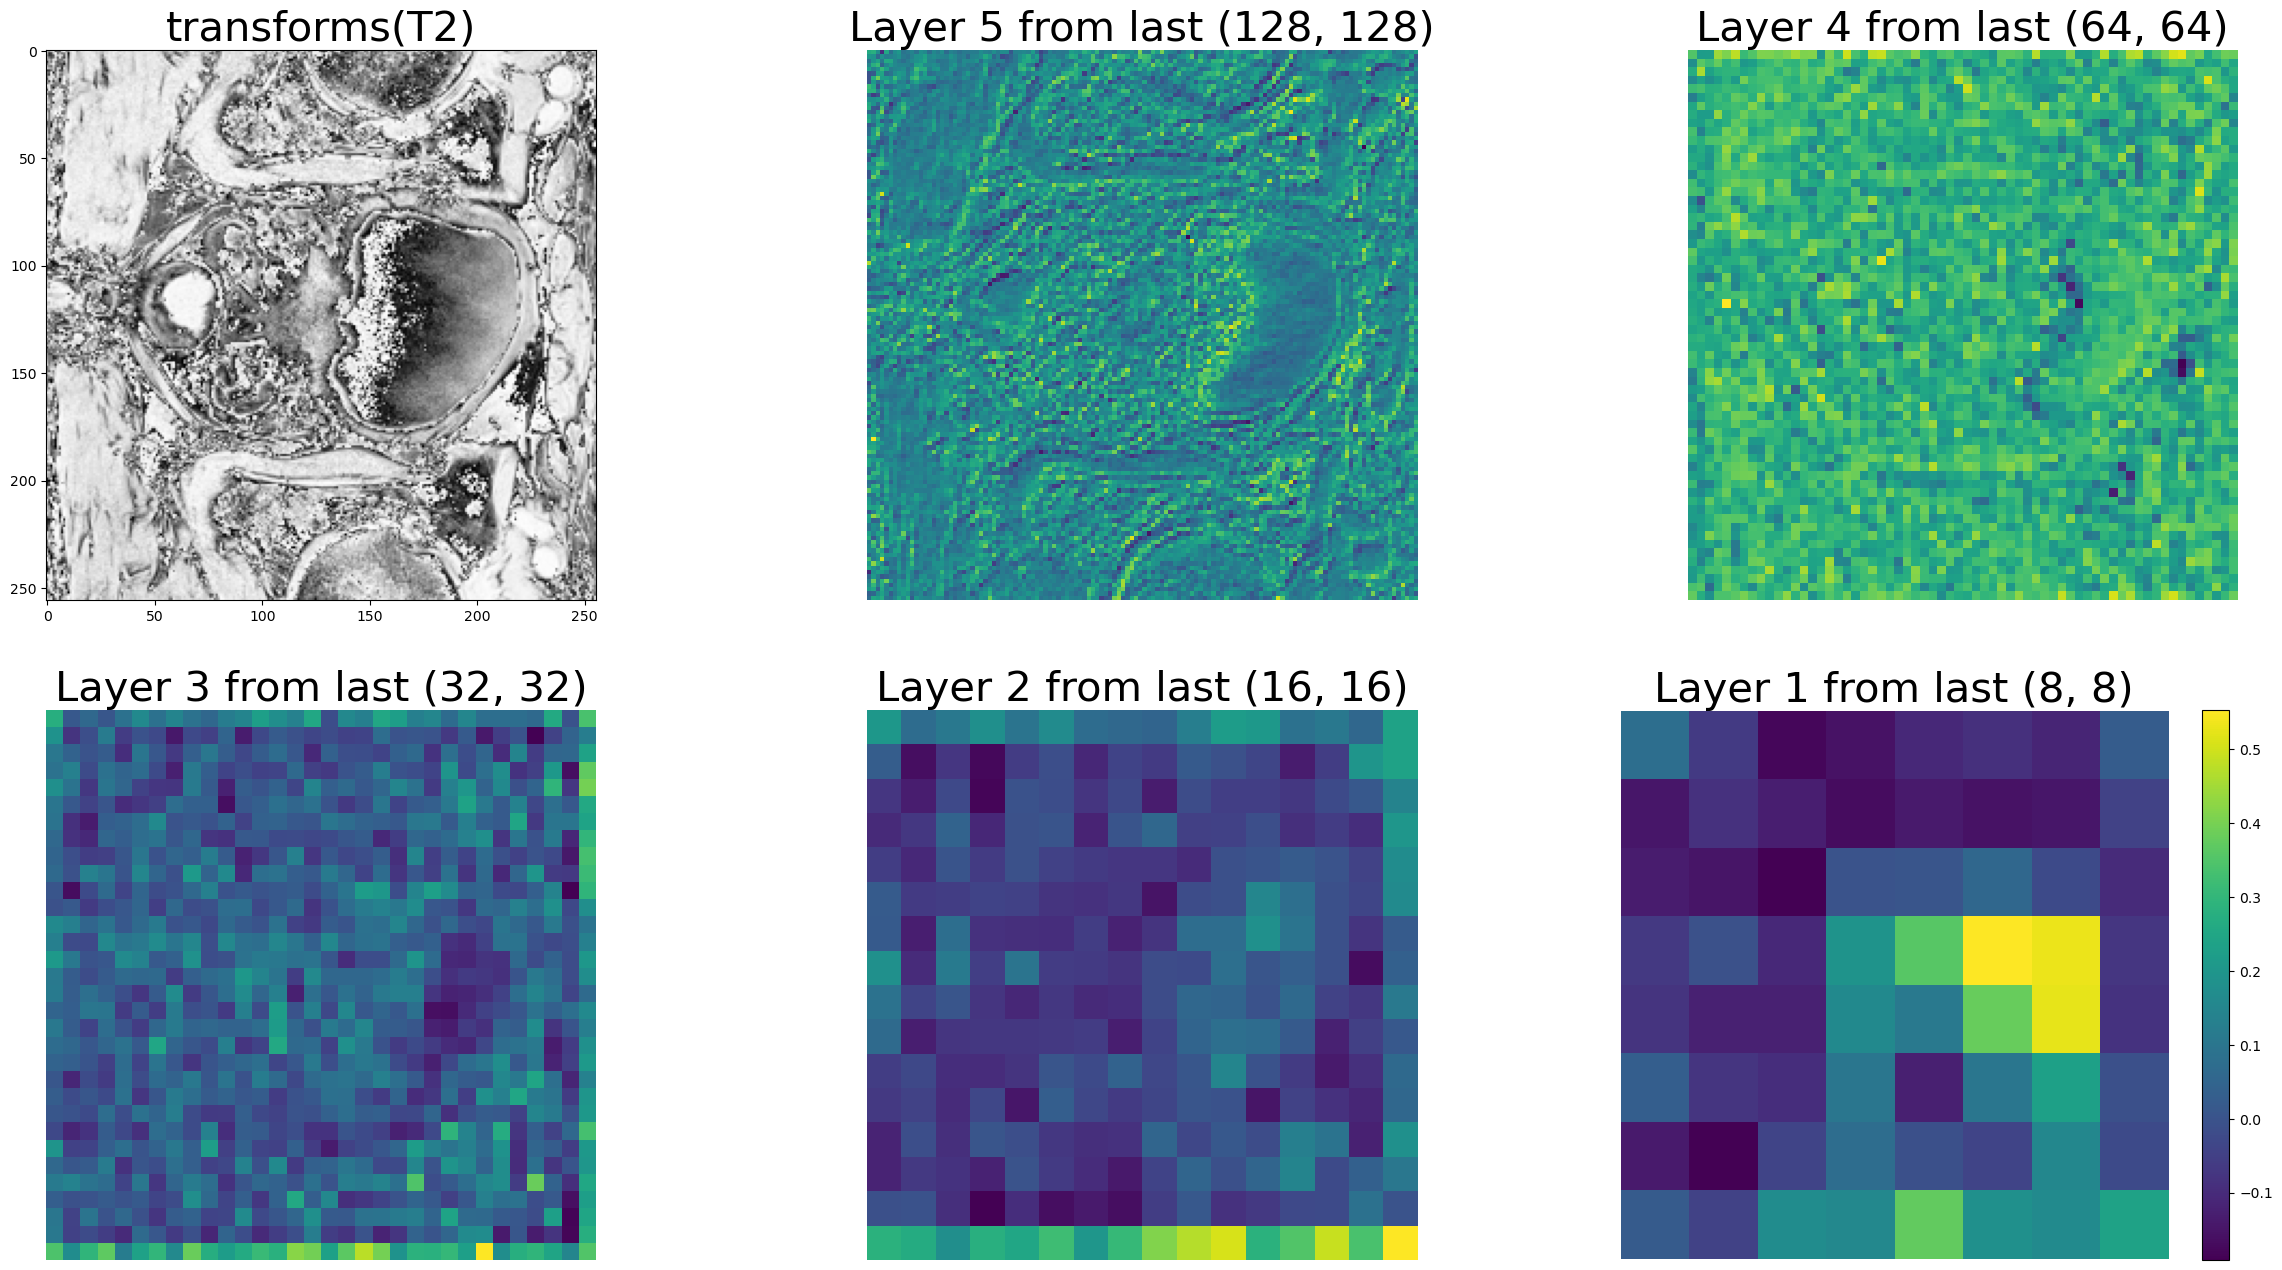

In [12]:
# temp output for T2 in m1
fig = plt.figure(figsize=(30, 50))
fig.add_subplot(6, 3, 1)
ori = plt.imshow(x.squeeze(0)[1,:,:], cmap='Greys_r'); plt.title("transforms(T2)", fontsize=30)

for i in range(len(fms)):
    a = fig.add_subplot(6, 3, i+2)
    imgplot = plt.imshow(fms[i])
    a.axis("off")
    a.set_title("Layer {} from last {}".format(len(fms)-i, fms[i].shape), fontsize=30)
#plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')
cbar = plt.colorbar()

### Example Codes from HF
https://huggingface.co/timm/mobilevitv2_050.cvnets_in1k 

In [15]:
# Example code from HF (Image Classification)
from urllib.request import urlopen
from PIL import Image
#import timm

img = Image.open(urlopen(
    'https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/beignets-task-guide.png'
))

model = timm.create_model('mobilevitv2_050.cvnets_in1k', pretrained=True)
model = model.eval()

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training=False)

x = transforms(img).unsqueeze(0)
output = model(x)  # unsqueeze single image into batch of 1

top5_probabilities, top5_class_indices = torch.topk(output.softmax(dim=1) * 100, k=5)


torch.Size([1, 3, 256, 256])


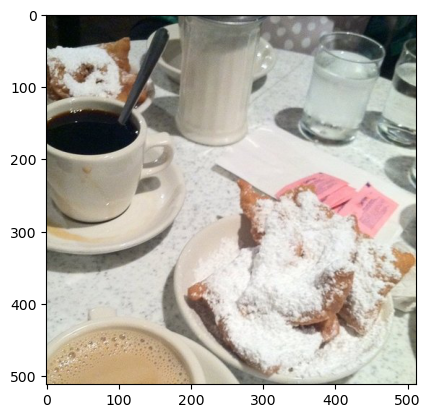

In [16]:
plt.imshow(img)
print(x.shape) #[1, 3, 256, 256]
#print(output)             #shape: [1, 1000]
#print(top5_class_indices) #[969, 967, 928, 960, 927]   shape: [1, 5]
#print(top5_probabilities) #[24.9318, 12.4587,  8.9054,  6.5909,  5.6044]  shape:[1, 5]

In [17]:
# Example code from HF (Feature Map Extraction)
from urllib.request import urlopen
from PIL import Image
import timm

img = Image.open(urlopen(
    'https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/beignets-task-guide.png'
))

model = timm.create_model(
    'mobilevitv2_050.cvnets_in1k',
    pretrained=True,
    features_only=True,
)
model = model.eval()

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training=False)

output = model(transforms(img).unsqueeze(0))  # unsqueeze single image into batch of 1

for o in output:
    # print shape of each feature map in output
    # e.g.:
    #  torch.Size([1, 32, 128, 128])
    #  torch.Size([1, 64, 64, 64])
    #  torch.Size([1, 128, 32, 32])
    #  torch.Size([1, 192, 16, 16])
    #  torch.Size([1, 256, 8, 8])

    print(o.shape)


torch.Size([1, 32, 128, 128])
torch.Size([1, 64, 64, 64])
torch.Size([1, 128, 32, 32])
torch.Size([1, 192, 16, 16])
torch.Size([1, 256, 8, 8])


In [5]:
# visualize feature map
processed = []

for feature_map in output:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    fm = gray_scale.data.cpu().numpy()
    processed.append(fm)

    print(fm.shape)
    #(128, 128)
    #(64, 64)
    #(32, 32)
    #(16, 16)
    #(8, 8)

(128, 128)
(64, 64)
(32, 32)
(16, 16)
(8, 8)


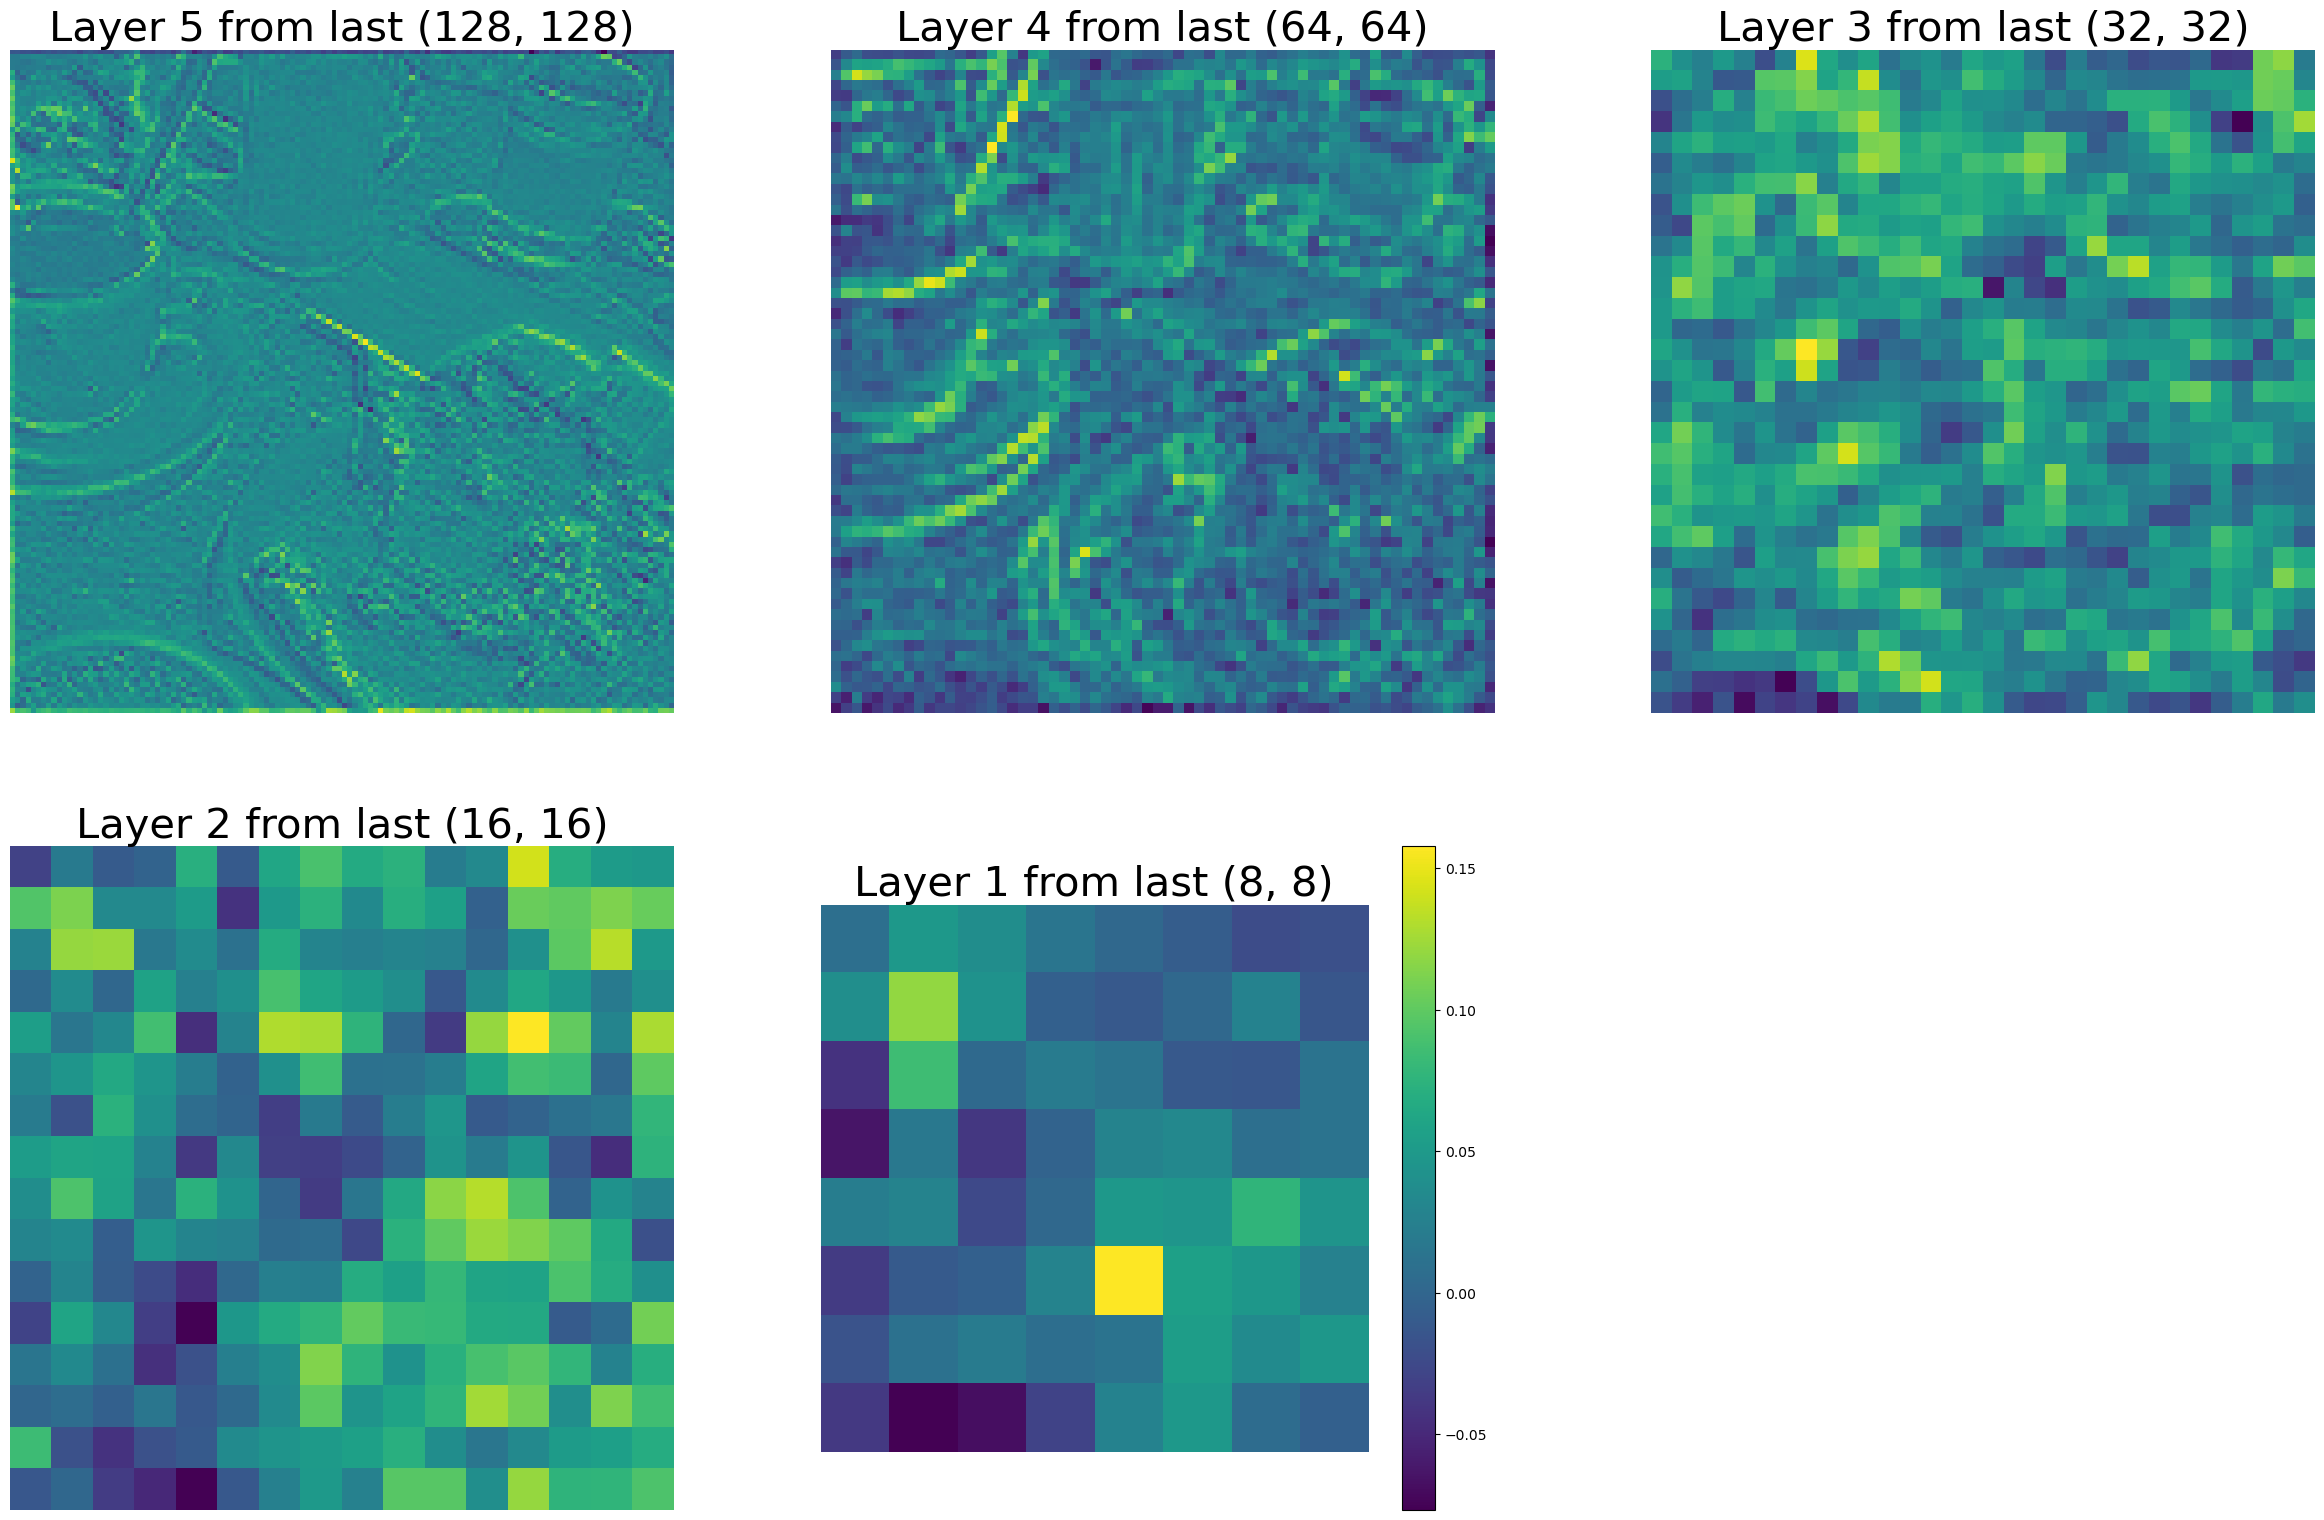

In [41]:
fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
    a = fig.add_subplot(5, 3, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title("Layer {} from last {}".format(len(processed)-i, processed[i].shape), fontsize=30)
#plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')
cbar = plt.colorbar()

In [4]:
# try different model v1
# Example code from HF (Feature Map Extraction)
from urllib.request import urlopen
from PIL import Image
import timm

img = Image.open(urlopen(
    'https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/beignets-task-guide.png'
))

model = timm.create_model(
    'mobilevit_xxs.cvnets_in1k',
    pretrained=True,
    features_only=True,
)
model = model.eval()

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training=False)

output = model(transforms(img).unsqueeze(0))  # unsqueeze single image into batch of 1

for o in output:
    # print shape of each feature map in output
    # e.g.:
    #  torch.Size([1, 16, 128, 128])
    #  torch.Size([1, 24, 64, 64])
    #  torch.Size([1, 48, 32, 32])
    #  torch.Size([1, 64, 16, 16])
    #  torch.Size([1, 320, 8, 8])

    # difference in dim[1]: 32,64,128,192,256 -> 16,24,48,64,320

    print(o.shape)


torch.Size([1, 16, 128, 128])
torch.Size([1, 24, 64, 64])
torch.Size([1, 48, 32, 32])
torch.Size([1, 64, 16, 16])
torch.Size([1, 320, 8, 8])


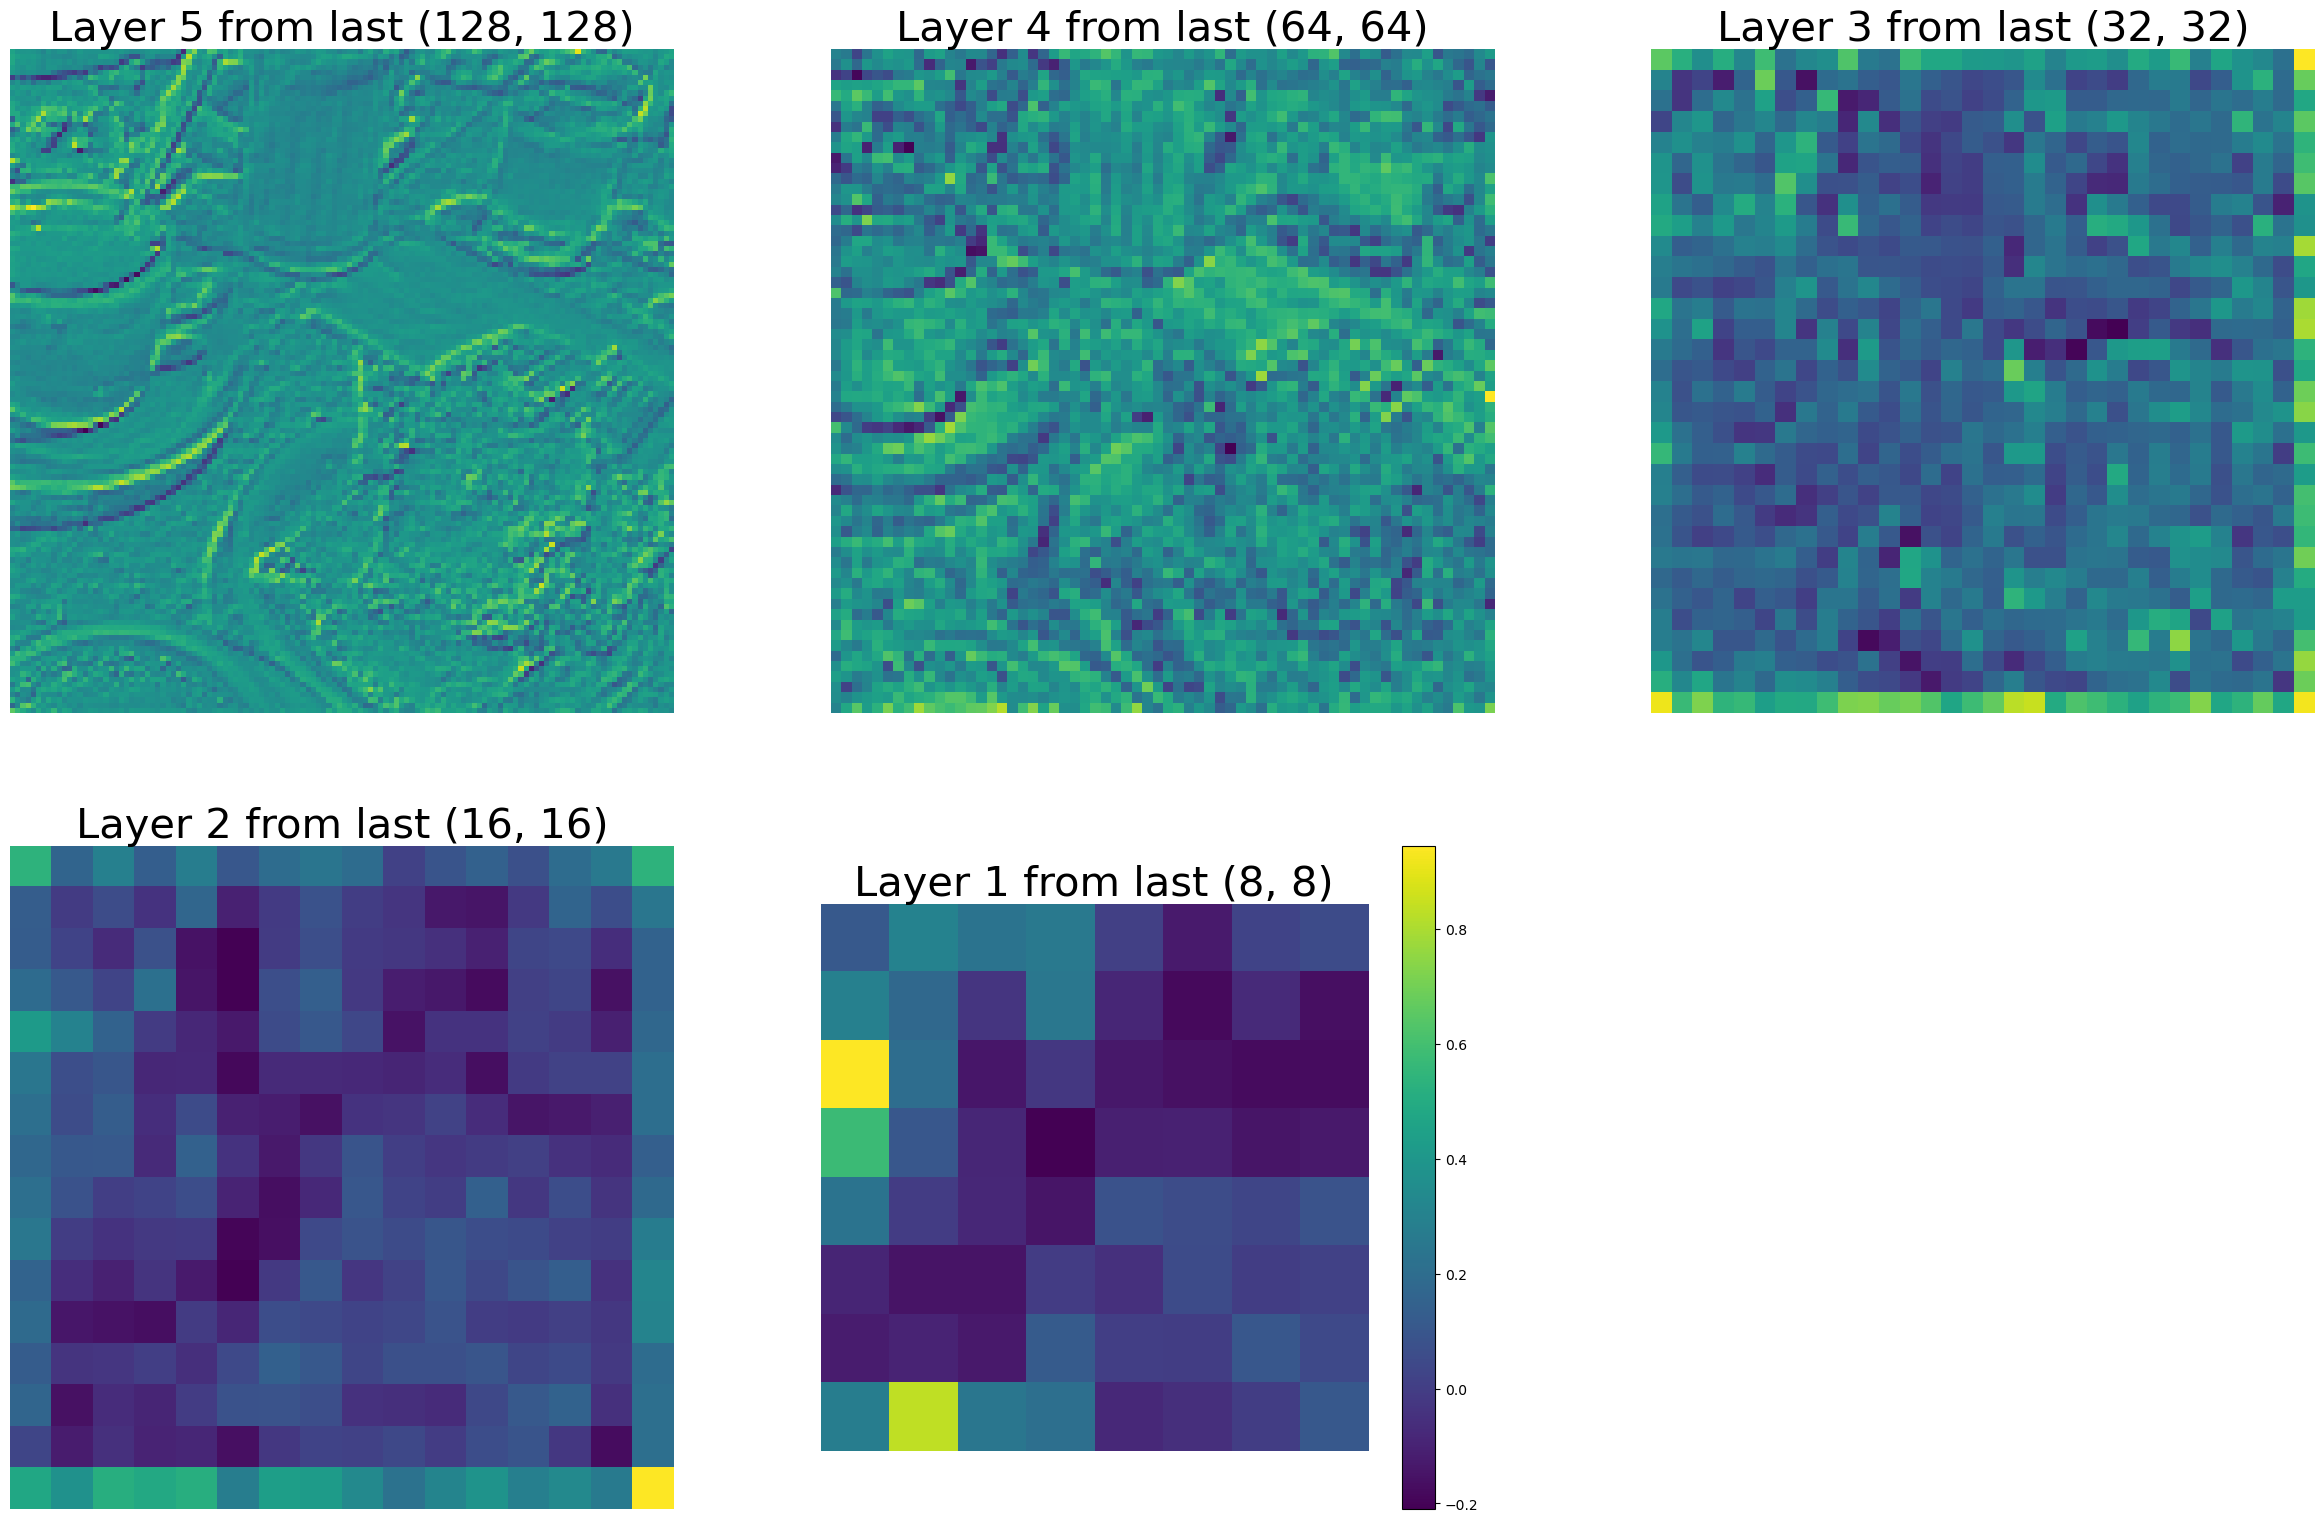

In [6]:
fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
    a = fig.add_subplot(5, 3, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title("Layer {} from last {}".format(len(processed)-i, processed[i].shape), fontsize=30)
#plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')
cbar = plt.colorbar()

In [43]:
# Example code from HF (Image Embedding)
from urllib.request import urlopen
from PIL import Image
import timm

img = Image.open(urlopen(
    'https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/beignets-task-guide.png'
))

model = timm.create_model(
    'mobilevitv2_050.cvnets_in1k',
    pretrained=True,
    num_classes=0,  # remove classifier nn.Linear, but still have global pooling?
)
model = model.eval()

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training=False)

output = model(transforms(img).unsqueeze(0))  # output is (batch_size, num_features) = [1, 256] tensor

# or equivalently (without needing to set num_classes=0)
#output = model.forward_features(transforms(img).unsqueeze(0)) #(1, 256, 8, 8) tensor
#output = model.forward_head(output, pre_logits=True) #(1, num_features) tensor

plt.imshow(img)
print(output)